### a.	Use past 60 days price to predict the price in one week (5 days). You can choose any stock.

In [ ]:
# enable and detect GPU

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Make sure the GPU device is correctly configured.")

Num GPUs Available:  0
GPU not found. Make sure the GPU device is correctly configured.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
import importlib.util
package_name = 'yfinance'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install yfinance

import yfinance as yf
df=yf.download(['NVDA'], start='2012-01-01', end='2024-01-25')

df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2012-01-03,0.321897,0.330151,0.321209,0.327858,468044000
2012-01-04,0.325565,0.326941,0.319146,0.322126,347372000
2012-01-05,0.337258,0.338863,0.322585,0.323960,563548000
2012-01-06,0.333360,0.337258,0.329463,0.337029,533252000
2012-01-09,0.333360,0.339780,0.331068,0.333590,508244000
...,...,...,...,...,...
2024-01-18,57.090813,57.583673,56.091096,57.243769,491650000
2024-01-19,59.474136,59.483133,57.208776,57.972559,543501000


In [ ]:
# Prepare train data

dataset = df['Close'].values
train_data_len = math.ceil(len(dataset) * 0.8)
train_data_len

#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

#Training dataset
n_period=60
n_steps_ahead=5
train_data=scaled_data[0:train_data_len]
x_train=[]
y_train=[]
for i in range(n_period, len(train_data) - n_steps_ahead):
    x_train.append(train_data[i-n_period:i,0])
    y_train.append(train_data[i:i + n_steps_ahead, 0])

#Convert numpy array
x_train, y_train=np.array(x_train), np.array(y_train)

#Reshape into 3D array
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(2363, 60, 1)

In [ ]:
#Build the LSTM model predicting next five days (Dense layer must give 5 outputs)
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(5))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train,y_train, batch_size=1, epochs=3)

Epoch 1/3
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - loss: 3.1036e-04
Epoch 2/3
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - loss: 9.9111e-05
Epoch 3/3
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 88s 34ms/step - loss: 9.1531e-05


In [ ]:
# Create Test Data

test_data=scaled_data[train_data_len-60:,:]
x_test=[]
y_test=dataset[train_data_len:,:]

for i in range(n_period, len(test_data)):
    x_test.append(test_data[i - n_period:i, 0])  # Use past 60 days for prediction

# Convert to numpy arrays and reshape for LSTM
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions_scaled = model.predict(x_test)

# Predictions should have shape (num_samples, 5)
print(f"Predictions shape: {predictions_scaled.shape}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Predictions shape: (606, 5)


In [ ]:
# Inverse transform the data
predictions=predictions_scaled*(scaler.data_max_[0]-scaler.data_min_[0])+scaler.data_min_[0]

#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.8364226822805877

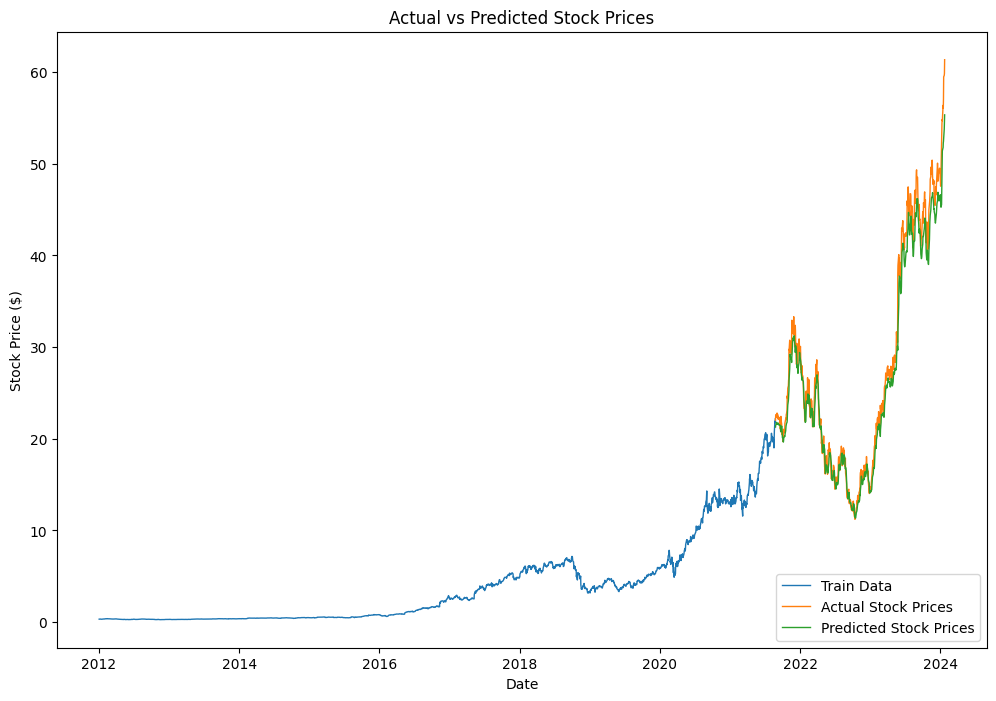

In [ ]:
data=df['Close']

train = data[:train_data_len]  # Training data (up to train_data_len)
valid = data[train_data_len:]  # Test data (after train_data_len)

# Create a dataframe for the validation with predictions
valid = valid.assign(Predictions=predictions[:,0])  # predictions[:,0] selects the first column if multi-step prediction

# Plot the actual and predicted values
plt.figure(figsize=(12,8))
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train, lw=1, label='Train Data')
plt.plot(valid['NVDA'], lw=1, label='Actual Stock Prices')  # Plot actual test data
plt.plot(valid['Predictions'], lw=1, label='Predicted Stock Prices')  # Plot predicted values
plt.legend(loc='lower right')
plt.show()

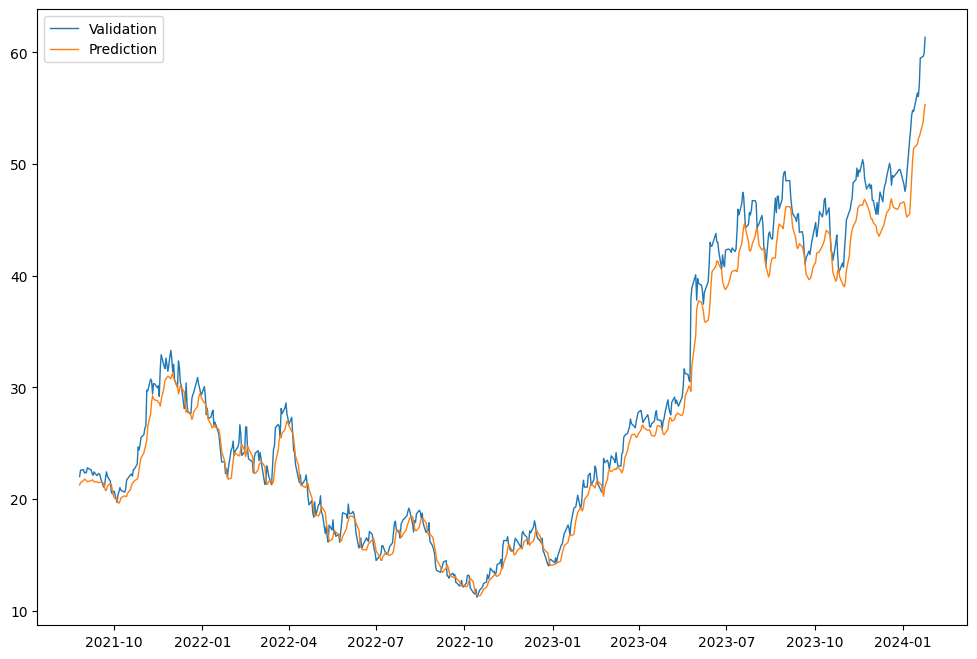

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(valid[['NVDA','Predictions']], lw=1)
plt.legend(['Validation', 'Prediction'])

In [ ]:
# ANSWER: Prediction for the next five days

next_5_days_prediction = predictions[-1]

next_5_days_prediction

array([55.331078, 55.70964 , 56.264427, 56.71262 , 56.57852 ],
      dtype=float32)

In [ ]:
len(predictions)

606


### b.	Use your prediction to generate trading signals for the testing period (20% of your dataset): if the predicted price is higher than the current price (you can specify a threshold), you should buy one share; if it is lower than the current price, you can short one share.

In [ ]:
# Select first predicted closing price out of the five predicted days
day_0_predictions = predictions[:, 0]

# Join onto original data
df.columns = df.columns.get_level_values(0)
prediction_start_index = train_data_len + n_period
test_period = df.reset_index()[['Date','Close']][len(df)-len(predictions):]
test_period['predictions'] = day_0_predictions

# Generate trading signal
test_period['trading_signal'] = test_period.apply(
    lambda row: 1 if row['Close'] < row['predictions'] else (-1 if row['Close'] > row['predictions'] else 0),
    axis=1
)

test_period

Price,Date,Close,predictions,trading_signal
2428,2021-08-26,22.024776,21.273029,-1
2429,2021-08-27,22.591663,21.470812,-1
2430,2021-08-30,22.643566,21.668491,-1
2431,2021-08-31,22.345098,21.793484,-1
2432,2021-09-01,22.400999,21.737925,-1
...,...,...,...,...
3029,2024-01-18,57.090813,52.438396,-1
3030,2024-01-19,59.474136,52.741547,-1
3031,2024-01-22,59.637093,53.782478,-1
3032,2024-01-23,59.856033,54.714127,-1


### c.	Assume that you will always close your position in one week, calculate your accumulated profit and loss for the testing data

In [ ]:
test_period.reset_index(inplace=True, drop=True)

In [ ]:
# Initialize a column to hold profit/loss values
test_period['profit_loss'] = 0.0

# Iterate over rows to calculate P&L for each trading signal
for i in range(len(test_period) - 5):  # Avoid index errors for the last 5 days
    signal = test_period.loc[i, 'trading_signal']
    current_price = test_period.loc[i, 'Close']
    close_price_5_days_later = test_period.loc[i + 5, 'Close']

    # Calculate P&L based on the trading signal
    if signal == 1:  # Buy signal
        test_period.loc[i, 'profit_loss'] = close_price_5_days_later - current_price
    elif signal == -1:  # Sell signal
        test_period.loc[i, 'profit_loss'] = current_price - close_price_5_days_later
    else:  # Hold signal
        test_period.loc[i, 'profit_loss'] = 0.0

# Calculate total accumulated profit/loss
total_profit_loss = test_period['profit_loss'].sum()

# Display the total P&L
print(f"Total Accumulated Profit/Loss: ${total_profit_loss:.2f}")

# Optionally, inspect the P&L for each trade
print(test_period[['Close', 'predictions', 'trading_signal', 'profit_loss']].head(10))

Total Accumulated Profit/Loss: $-145.98
Price      Close  predictions  trading_signal  profit_loss
0      22.024776    21.273029              -1    -0.331299
1      22.591663    21.470812              -1    -0.210617
2      22.643566    21.668491              -1     0.021961
3      22.345098    21.793484              -1     0.045921
4      22.400999    21.737925              -1     0.263533
5      22.356075    21.649792              -1    -0.081856
6      22.802280    21.562479              -1     0.689766
7      22.621605    21.657137              -1     0.419252
8      22.299177    21.730501              -1    -0.001995
9      22.137466    21.676390              -1    -0.064886


### d.	Repeat a.)-d.) with additional features of your choice (eg, SP500, VIX, etc).

In [ ]:
import yfinance as yf
df=yf.download(['VOO'], start='2012-01-01', end='2024-01-25')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Prepare train data

dataset = df['Close'].values
train_data_len = math.ceil(len(dataset) * 0.8)
train_data_len

#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

#Training dataset
n_period=60
n_steps_ahead=5
train_data=scaled_data[0:train_data_len]
x_train=[]
y_train=[]
for i in range(n_period, len(train_data) - n_steps_ahead):
    x_train.append(train_data[i-n_period:i,0])
    y_train.append(train_data[i:i + n_steps_ahead, 0])

#Convert numpy array
x_train, y_train=np.array(x_train), np.array(y_train)

#Reshape into 3D array
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

#Build the LSTM model predicting next five days (Dense layer must give 5 outputs)
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(5))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train, batch_size=1, epochs=3)

# Create Test Data

test_data=scaled_data[train_data_len-60:,:]
x_test=[]
y_test=dataset[train_data_len:,:]

for i in range(n_period, len(test_data)):
    x_test.append(test_data[i - n_period:i, 0])  # Use past 60 days for prediction

# Convert to numpy arrays and reshape for LSTM
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions_scaled = model.predict(x_test)

# Predictions should have shape (num_samples, 5)
print(f"Predictions shape: {predictions_scaled.shape}")

# Inverse transform the data
predictions=predictions_scaled*(scaler.data_max_[0]-scaler.data_min_[0])+scaler.data_min_[0]

#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse



Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2363/2363 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - loss: 0.0032
Epoch 2/3
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - loss: 4.5480e-04
Epoch 3/3
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - loss: 4.3269e-04
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Predictions shape: (606, 5)


15.904100253164964

In [ ]:
# Select first predicted price
day_0_predictions = predictions[:, 0]

# Join onto original data
df.columns = df.columns.get_level_values(0)
prediction_start_index = train_data_len + n_period
test_period = df.reset_index()[['Date','Close']][len(df)-len(predictions):]
test_period['predictions'] = day_0_predictions

# Generate trading signal
test_period['trading_signal'] = test_period.apply(
    lambda row: 1 if row['Close'] < row['predictions'] else (-1 if row['Close'] > row['predictions'] else 0),
    axis=1
)

test_period

Price,Date,Close,predictions,trading_signal
2428,2021-08-26,389.210358,370.716217,-1
2429,2021-08-27,392.664032,370.927216,-1
2430,2021-08-30,394.466766,371.713745,-1
2431,2021-08-31,393.793060,372.842651,-1
2432,2021-09-01,394.210510,373.478668,-1
...,...,...,...,...
3029,2024-01-18,432.246033,404.847931,-1
3030,2024-01-19,437.536469,404.942139,-1
3031,2024-01-22,438.533325,406.770569,-1
3032,2024-01-23,439.836151,408.728058,-1


In [ ]:
test_period.reset_index(inplace=True, drop=True)

# Initialize a column to hold profit/loss values
test_period['profit_loss'] = 0.0

# Iterate over rows to calculate P&L for each trading signal
for i in range(len(test_period) - 5):  # Avoid index errors for the last 5 days
    signal = test_period.loc[i, 'trading_signal']
    current_price = test_period.loc[i, 'Close']
    close_price_5_days_later = test_period.loc[i + 5, 'Close']

    # Calculate P&L based on the trading signal
    if signal == 1:  # Buy signal
        test_period.loc[i, 'profit_loss'] = close_price_5_days_later - current_price
    elif signal == -1:  # Sell signal
        test_period.loc[i, 'profit_loss'] = current_price - close_price_5_days_later
    else:  # Hold signal
        test_period.loc[i, 'profit_loss'] = 0.0

# Calculate total accumulated profit/loss
total_profit_loss = test_period['profit_loss'].sum()

# Display the total P&L
print(f"Total Accumulated Profit/Loss: ${total_profit_loss:.2f}")

# Optionally, inspect the P&L for each trade
print(test_period[['Close', 'predictions', 'trading_signal', 'profit_loss']].head(10))

Total Accumulated Profit/Loss: $-252.21
Price       Close  predictions  trading_signal  profit_loss
0      389.210358   370.716217              -1    -6.176636
1      392.664032   370.927216              -1    -2.571136
2      394.466766   371.713745              -1     0.692719
3      393.793060   372.842651              -1     0.398529
4      394.210510   373.478668              -1     2.580750
5      395.386993   373.872253              -1     6.783813
6      395.235168   374.365326              -1     5.721130
7      393.774048   374.647491              -1     6.280945
8      393.394531   374.349426              -1     2.666016
9      391.629761   373.876282              -1     1.574921


### e.	Instead of generating trading signals from predicted price as in b.), train your model with consistent criteria (eg, target=1 if the price in 5 days increases more than the threshold,   = -1 if it decreases by more than the threshold, and =0 otherwise), and compare your model performance.

In [ ]:
test_period.drop(columns=['trading_signal','profit_loss','predictions'], inplace=True)

test_period['avg_5day_predictions'] = np.mean(predictions, axis=1).tolist()
test_period['trading_signal'] = test_period.apply(
    lambda row: 1 if row.iloc[:-1]['Close'] < row['avg_5day_predictions'] else (-1 if row['Close'] > row['avg_5day_predictions'] else 0),
    axis=1
)

test_period['daily_pct_increase'] = test_period['avg_5day_predictions'].pct_change()*100

# Generate trading signal - 1 if daily pct increase is positive, -1 if it's negative, if no change then hold position
test_period['trading_signal'] = test_period.apply(
    lambda row: 1 if row['daily_pct_increase'] > 0 else (-1 if row['daily_pct_increase'] < 0 else 0),
    axis=1
)

In [ ]:
test_period.reset_index(inplace=True, drop=True)

# Initialize a column to hold profit/loss values
test_period['profit_loss'] = 0.0

# Iterate over rows to calculate P&L for each trading signal
for i in range(len(test_period) - 5):  # Avoid index errors for the last 5 days
    signal = test_period.loc[i, 'trading_signal']
    current_price = test_period.loc[i, 'Close']
    close_price_5_days_later = test_period.loc[i + 5, 'Close']

    # Calculate P&L based on the trading signal
    if signal == 1:  # Buy signal
        test_period.loc[i, 'profit_loss'] = close_price_5_days_later - current_price
    elif signal == -1:  # Sell signal
        test_period.loc[i, 'profit_loss'] = current_price - close_price_5_days_later
    else:  # Hold signal
        test_period.loc[i, 'profit_loss'] = 0.0

# Calculate total accumulated profit/loss
total_profit_loss = test_period['profit_loss'].sum()

# Display the total P&L
print(f"Total Accumulated Profit/Loss: ${total_profit_loss:.2f}")

# Optionally, inspect the P&L for each trade
print(test_period[['Close', 'avg_5day_predictions', 'trading_signal', 'profit_loss']].head(10))

Total Accumulated Profit/Loss: $42.96
Price       Close  avg_5day_predictions  trading_signal  profit_loss
0      389.210358            373.029144               0     0.000000
1      392.664032            373.342590               1     2.571136
2      394.466766            374.192871               1    -0.692719
3      393.793060            375.389557               1    -0.398529
4      394.210510            376.085632               1    -2.580750
5      395.386993            376.508545               1    -6.783813
6      395.235168            377.009735               1    -5.721130
7      393.774048            377.286621               1    -6.280945
8      393.394531            376.955139              -1     2.666016
9      391.629761            376.415955              -1     1.574921
